# Connecting Mocks and Spectra Examples

The purpose of this notebook is to demonstrate how to generate spectra and apply target selection cuts for various mock catalogs and target types.  Here we generate spectra for targets in a single healpixel with no constraints on the target density (relative to the expected target density) or contaminants.

For code to generate large numbers of spectra over significant patches of sky and to create a representative DESI dataset (with parallelism), see `desitarget/bin/select_mock_targets` and `desitarget.mock.build.targets_truth`.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from desitarget.mock.mockmaker import (QSOMaker, LYAMaker, LRGMaker, ELGMaker, 
                                       BGSMaker, MWS_MAINMaker, MWS_NEARBYMaker,
                                       WDMaker, FAINTSTARMaker, SKYMaker)

In [3]:
plt.style.use('seaborn-ticks')
%matplotlib inline

#### Specify the (required) path to the dust maps and the desired healpixel.

In [4]:
dust_dir = '/Users/ioannis/research/data/sfd_dustmaps/maps'

In [5]:
healpixel = 26030
nside = 64

In [6]:
seed = 555
rand = np.random.RandomState(seed)

### Tracer and Lya QSOs.

Both tracer and Lya QSOs contain an underlying QSO spectrum but the Lya QSOs also include the Lya forest from the latest CoLoRe skewer mocks.

In [7]:
QSO = QSOMaker(seed=seed)

#### The various `read` methods return a dictionary with target-specific quantities.

In [8]:
data = QSO.read(healpixels=healpixel, nside=nside, dust_dir=dust_dir)

INFO:mockmaker.py:566:readmock: Reading /Users/ioannis/work/desi/mocks/GaussianRandomField/v0.0.5/QSO.fits
INFO:mockmaker.py:578:readmock: Assigning healpix pixels with nside = 64
INFO:mockmaker.py:587:readmock: Trimmed to 114 QSOs in healpixel(s) 26030


In [9]:
for key in sorted(list(data.keys())):
    print('{:>20}, {:3d}, {}'.format(key, len(data[key]), type(data[key])))

           BRICKNAME, 114, <class 'numpy.ndarray'>
                 DEC, 114, <class 'numpy.ndarray'>
                 EBV, 114, <class 'numpy.ndarray'>
               FILES,   1, <class 'list'>
          GALDEPTH_G, 114, <class 'numpy.ndarray'>
          GALDEPTH_R, 114, <class 'numpy.ndarray'>
          GALDEPTH_Z, 114, <class 'numpy.ndarray'>
          MOCKFORMAT,  13, <class 'str'>
              MOCKID, 114, <class 'numpy.ndarray'>
   MW_TRANSMISSION_G, 114, <class 'numpy.ndarray'>
   MW_TRANSMISSION_R, 114, <class 'numpy.ndarray'>
  MW_TRANSMISSION_W1, 114, <class 'numpy.ndarray'>
  MW_TRANSMISSION_W2, 114, <class 'numpy.ndarray'>
   MW_TRANSMISSION_Z, 114, <class 'numpy.ndarray'>
          N_PER_FILE,   1, <class 'list'>
               OBJID, 114, <class 'numpy.ndarray'>
          PSFDEPTH_G, 114, <class 'numpy.ndarray'>
          PSFDEPTH_R, 114, <class 'numpy.ndarray'>
         PSFDEPTH_W1, 114, <class 'numpy.ndarray'>
         PSFDEPTH_W2, 114, <class 'numpy.ndarray'>
        

#### Now we can generate the spectra as well as the targeting catalogs (`targets`) and corresponding truth table.

In [10]:
%time flux, wave, meta, targets, truth = QSO.make_spectra(data)

CPU times: user 4.28 s, sys: 225 ms, total: 4.5 s
Wall time: 4.64 s


In [11]:
print(flux.shape, wave.shape)

(114, 32001) (32001,)


#### The truth (and meta) catalog contains all the input, known target properties.

In [12]:
truth[:2]

TARGETID,MOCKID,CONTAM_TARGET,TRUEZ,TRUESPECTYPE,TEMPLATETYPE,TEMPLATESUBTYPE,TEMPLATEID,SEED,MAG,VDISP,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,TEFF,LOGG,FEH
,,,,,,,,,mag,km / s,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,erg / (cm2 s),erg / (cm2 s),K,m / s2,
int64,int64,int64,float32,str10,str10,str10,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0,495878,0,0.139552,QSO,QSO,,0,3083073946,21.3426,-1.0,2.90382,2.99851,3.13995,19.3509,26.174,-1.0,-1.0,-1.0,-1.0,-1.0
0,502558,0,0.43569,QSO,QSO,,1,3083073946,19.682,-1.0,13.4024,13.8509,19.9141,92.6185,139.872,-1.0,-1.0,-1.0,-1.0,-1.0


In [13]:
meta[:2]

OBJTYPE,SUBTYPE,TEMPLATEID,SEED,REDSHIFT,MAG,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,EWOII,EWHBETA,D4000,VDISP,OIIDOUBLET,OIIIHBETA,OIIHBETA,NIIHBETA,SIIHBETA,ZMETAL,AGE,TEFF,LOGG,FEH
,,,,,mag,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,erg / (cm2 s),erg / (cm2 s),Angstrom,Angstrom,,km / s,,dex,dex,dex,dex,,Gyr,K,m / s2,
str10,str10,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
QSO,,0,3083073946,0.139552,21.3426,2.90382,2.99851,3.13995,19.3509,26.174,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
QSO,,1,3083073946,0.43569,19.682,13.4024,13.8509,19.9141,92.6185,139.872,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


#### Let's plot some example spectra.

In [14]:
def plot_subset(wave, flux, truth, nplot=16, ncol=4):
    """Plot a random sampling of spectra."""
    nspec, npix = flux.shape
    nrow = np.ceil(nplot / ncol).astype('int')
    these = rand.choice(nspec, nplot, replace=False)
    these = np.sort(these)
    ww = (wave > 5500) * (wave < 5550)

    fig, ax = plt.subplots(nrow, ncol, figsize=(2.5*ncol, 2*nrow), sharey=False, sharex=True)
    for thisax, indx in zip(ax.flat, these):
        thisax.plot(wave, flux[indx, :] / np.median(flux[indx, ww]))
        thisax.text(0.95, 0.93, 'z={:.3f}'.format(truth['TRUEZ'][indx]), ha='right', 
             va='top', transform=thisax.transAxes, fontsize=11)
        thisax.xaxis.set_major_locator(plt.MaxNLocator(3))
        thisax.yaxis.set_ticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)


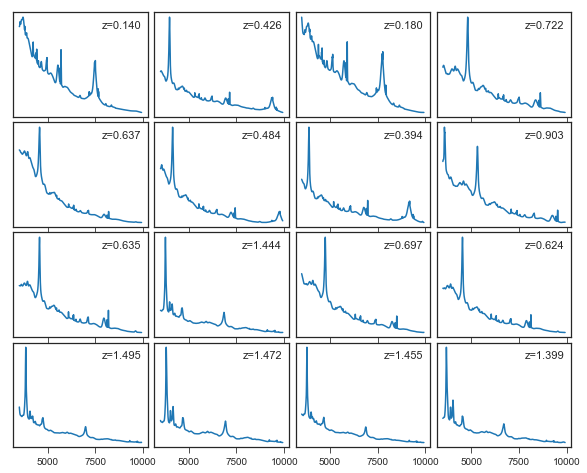

In [15]:
plot_subset(wave, flux, truth)

#### Select DESI targets, after which point the targets catalog should look just like an imaging targeting catalog.

In other words, `targets` includes noisy photometry as well as targeting information.

In [16]:
QSO.select_targets(targets, truth)

In [17]:
targets[:2]

BRICKID,BRICKNAME,BRICK_OBJID,RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,PSFDEPTH_W1,PSFDEPTH_W2,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SUBPRIORITY,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,HPXPIXEL,OBSCONDITIONS
,,,deg,deg,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,,,,,,1/nanomaggies**2,1/nanomaggies**2,1/nanomaggies**2,1/nanomaggies**2,1/nanomaggies**2,1/nanomaggies**2,1/nanomaggies**2,1/nanomaggies**2,arcsec,,,arcsec,,,,,,,,,
int32,str8,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,int64,int64,int64,int64,int64,int64
0,2043p012,0,204.350891113,1.33589243889,2.90792,3.07249,3.37186,18.8122,26.2715,0.939729,0.95899,0.976661,0.996448,0.997817,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,0.0276732,0.438591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,262148,0,0,0,1
0,2046p007,0,204.55027771,0.717863500118,13.4122,13.756,19.8207,89.4035,139.577,0.931901,0.953602,0.973562,0.99597,0.997523,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,0.0276732,0.438591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,262148,0,0,0,1


In [18]:
keep = targets['DESI_TARGET'] != 0
print('Identified {} / {} QSO targets.'.format(np.sum(keep), len(targets)))

Identified 101 / 114 QSO targets.


### Generating Lya QSO spectra proceeds along similar lines.

In [19]:
#LYA = LYAMaker()

NameError: name 'verbose' is not defined

In [ ]:
#ldata = LYA.read(healpixels=healpixel, nside=nside, dust_dir=dust_dir)

In [ ]:
stop

### Now demonstrate the other extragalactic target classes: LRG, ELG, and BGS.

In [22]:
for Maker in (LRGMaker, ELGMaker, BGSMaker):
    TARGET = Maker(seed=seed)
    
    print('Reading the mock catalog for {}s'.format(TARGET.objtype))
    tdata = TARGET.read(healpixels=healpixel, nside=nside, dust_dir=dust_dir)
    
    print('Generating spectra.')
    indx = rand.choice(20, len(tdata['RA']))
    tflux, _, tmeta, ttargets, ttruth = TARGET.make_spectra(tdata, indx=indx)
    
    print('Selecting targets')
    TARGET.select_targets(ttargets, ttruth)

    print()

INFO:io.py:962:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/lrg_templates_v2.0.fits metadata.
Reading the mock catalog for LRGs
INFO:mockmaker.py:566:readmock: Reading /Users/ioannis/work/desi/mocks/GaussianRandomField/v0.0.5/LRG.fits
INFO:mockmaker.py:578:readmock: Assigning healpix pixels with nside = 64
INFO:mockmaker.py:587:readmock: Trimmed to 678 LRGs in healpixel(s) 26030
INFO:io.py:974:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/lrg_templates_v2.0.fits
Generating spectra.
Selecting targets

INFO:io.py:962:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/elg_templates_v2.0.fits metadata.
Reading the mock catalog for ELGs


ValueError: 